In [1]:
import numpy as np 
import pandas as pd
import torch
import math
from os import listdir
import numpy as np
from torch.autograd import Variable
from PIL import Image
from os.path import join

from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
from torch.utils.data import DataLoader, Dataset

In [5]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])

def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])



In [6]:
class TrainDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)

In [4]:
UPSCALE_FACTOR = 4
CROP_SIZE = 112

In [23]:
data_path='D:/Huy/eKyc/camera/SR/GPEN/celebaHQ/celebaHQ128/data128x128/'
train_set = TrainDatasetFromFolder(data_path, crop_size=CROP_SIZE, upscale_factor=UPSCALE_FACTOR)
# val_set = ValDatasetFromFolder('DIV2K_valid_HR', upscale_factor=UPSCALE_FACTOR)
train_loader = DataLoader(dataset=train_set, batch_size=36, shuffle=True,)
# val_loader = DataLoader(dataset=val_set, num_workers=4, batch_size=1, shuffle=False)

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

## Model


In [7]:
from torch import nn, optim
# Tạo các block cơ bản
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual
class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x
    
# Mạng sinh (Generator)   
class Generator(nn.Module):
    def __init__(self, scale_factor):
        upsample_block_num = int(math.log(scale_factor, 2))

        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        block8 = [UpsampleBLock(64, 2) for _ in range(upsample_block_num)]
        block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)

        return (torch.tanh(block8))

# Mạng phân biệt (Discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        return torch.sigmoid(self.net(x).view(batch_size))

In [8]:
# total-variation loss function
class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size
    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]

In [9]:
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
#         model face recogniton
        arcface = torch.load('mobifacenet.pth')
        loss_network = arcface.eval()
        for param in loss_network.parameters():
            param.requires_grad = False
            
        self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss()

    def forward(self, out_labels, out_images, target_images):
        # Adversarial Loss
        adversarial_loss = torch.mean(1 - out_labels)
        # Perception Loss
        perception_loss = self.mse_loss(self.loss_network(out_images), self.loss_network(target_images))
        # Image Loss
        image_loss = self.mse_loss(out_images, target_images)
        # TV Loss
        tv_loss = self.tv_loss(out_images)
        return image_loss + 0.001 * adversarial_loss + 0.06 * perception_loss + 2e-8 * tv_loss
#         return image_loss  + perception_loss 


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
netG = Generator(4)
netD = Discriminator()
generator_criterion = GeneratorLoss()

FileNotFoundError: [Errno 2] No such file or directory: 'mobifacenet.pth'

In [12]:
from torchsummary import summary
summary(netG,(3,112,112), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]          15,616
             PReLU-2         [-1, 64, 112, 112]               1
            Conv2d-3         [-1, 64, 112, 112]          36,928
       BatchNorm2d-4         [-1, 64, 112, 112]             128
             PReLU-5         [-1, 64, 112, 112]               1
            Conv2d-6         [-1, 64, 112, 112]          36,928
       BatchNorm2d-7         [-1, 64, 112, 112]             128
     ResidualBlock-8         [-1, 64, 112, 112]               0
            Conv2d-9         [-1, 64, 112, 112]          36,928
      BatchNorm2d-10         [-1, 64, 112, 112]             128
            PReLU-11         [-1, 64, 112, 112]               1
           Conv2d-12         [-1, 64, 112, 112]          36,928
      BatchNorm2d-13         [-1, 64, 112, 112]             128
    ResidualBlock-14         [-1, 64, 1

In [32]:
generator_criterion = generator_criterion.to(device)
netG = netG.to(device)
netD = netD.to(device)

In [33]:
# netG=torch.load('super_res_gen_arcface.pth')
# netD=torch.load('D_super_res_gen.pth')

In [34]:
optimizerG = optim.Adam(netG.parameters(), lr=0.0001)
optimizerD = optim.Adam(netD.parameters(), lr=0.0001)

In [35]:
results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}

In [36]:
from tqdm import tqdm
import os

In [37]:
N_EPOCHS = 100

In [69]:
import os
sample_dir = 'SRGAN_Face'
os.makedirs(sample_dir, exist_ok=True)
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import save_image
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

data_fix, target_fix=next(iter(train_loader))
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def save_samples(index, data, show=True):
    netG.eval()
    data=data.to(device)
    fake_images = netG(data)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=6)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=6).permute(1, 2, 0))
    return fake_images
        


In [60]:
data_fix.min()

tensor(0.)

In [41]:
for epoch in range(1, N_EPOCHS + 1):
    train_bar = tqdm(train_loader)
    running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}

    netG.train()
    netD.train()
    for data, target in train_bar:
        g_update_first = True
        batch_size = data.size(0)
        running_results['batch_sizes'] += batch_size
        
        real_img = Variable(target)
        if torch.cuda.is_available():
            real_img = real_img.cuda()
        z = Variable(data)
        if torch.cuda.is_available():
            z = z.cuda()
        
        ############################
        # (1) Update D network: maximize D(x)-1-D(G(z))
        ###########################
        fake_img = netG(z)

        netD.zero_grad()
        real_out = netD(real_img).mean()
        fake_out = netD(fake_img).mean()
        d_loss = 1 - real_out + fake_out
        d_loss.backward(retain_graph=True)
        optimizerD.step()

        ############################
        # (2) Update G network: minimize 1-D(G(z)) + Perception Loss + Image Loss + TV Loss
        ###########################
        ###### Was causing Runtime Error ######
        fake_img = netG(z)
        fake_out = netD(fake_img).mean()
        #######################################
        netG.zero_grad()
        g_loss = generator_criterion(fake_out, fake_img, real_img)
        g_loss.backward()

        fake_img = netG(z)
        fake_out = netD(fake_img).mean()

        optimizerG.step()

        # loss for current batch before optimization 
        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.item() * batch_size
        running_results['g_score'] += fake_out.item() * batch_size

        train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' % (
            epoch, N_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
            running_results['g_loss'] / running_results['batch_sizes'],
            running_results['d_score'] / running_results['batch_sizes'],
            running_results['g_score'] / running_results['batch_sizes']))

    netG.eval()
    out_path = 'training_results/SRF_' + str(UPSCALE_FACTOR) + '/'
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    save_samples(epoch, data_fix, show=True)

[1/100] Loss_D: 0.0868 Loss_G: 0.0184 D(x): 0.9533 D(G(z)): 0.0310: 100%|████████████| 834/834 [16:30<00:00,  1.19s/it]


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0001.png


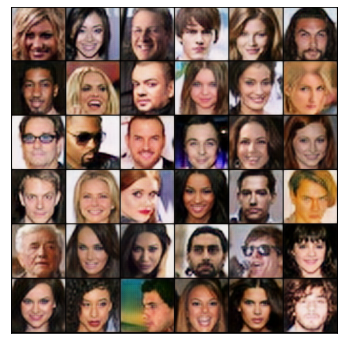

In [70]:
fake_images=save_samples(epoch, data_fix, show=True)

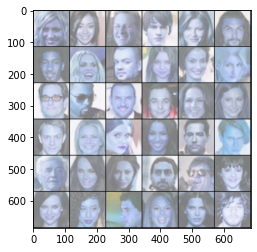

In [76]:
plt.imshow(cv2.imread('SRGAN_Face/generated-images-0001.png', cv2.COLOR_BGR2RGB))

In [ ]:
torch.save(netG, "super_res_gen_arcface.pth")
torch.save(netD, "D_super_res_gen_arcface.pth")

In [ ]:
# g=torch.load('super_res_gen.pth')

In [ ]:
g()

In [44]:
import cv2

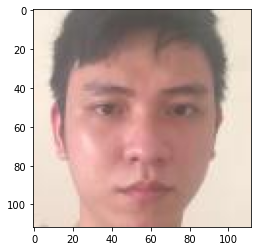

In [45]:
img=cv2.imread("D:/Huy/SOTA/data/Grooo/Huy_nv/img14.jpg")
img_c=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_c)
img= cv2.resize(img_c,(28,28))

In [46]:
img_c.shape

(112, 112, 3)

In [47]:
x=torch.Tensor([img])
x=x.permute(0, 3, 1, 2)
x.shape

torch.Size([1, 3, 28, 28])

In [48]:
o=netG(x.cuda()/255)

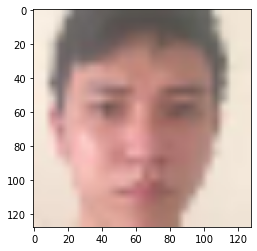

In [50]:
plt.imshow(cv2.resize(img,(128,128)))

In [51]:
img_sr=cv2.resize(cv2.resize(img_c,(28,28)),(112,112))
(img_sr-127.5)/128

array([[[0.94140625, 0.86328125, 0.76953125],
        [0.94140625, 0.86328125, 0.76953125],
        [0.94140625, 0.86328125, 0.76953125],
        ...,
        [0.89453125, 0.80078125, 0.67578125],
        [0.89453125, 0.80078125, 0.67578125],
        [0.89453125, 0.80078125, 0.67578125]],

       [[0.94140625, 0.86328125, 0.76953125],
        [0.94140625, 0.86328125, 0.76953125],
        [0.94140625, 0.86328125, 0.76953125],
        ...,
        [0.89453125, 0.80078125, 0.67578125],
        [0.89453125, 0.80078125, 0.67578125],
        [0.89453125, 0.80078125, 0.67578125]],

       [[0.94140625, 0.86328125, 0.76953125],
        [0.94140625, 0.86328125, 0.76953125],
        [0.94140625, 0.86328125, 0.76953125],
        ...,
        [0.89453125, 0.80078125, 0.67578125],
        [0.89453125, 0.80078125, 0.67578125],
        [0.89453125, 0.80078125, 0.67578125]],

       ...,

       [[0.87109375, 0.74609375, 0.64453125],
        [0.87109375, 0.74609375, 0.64453125],
        [0.86328125, 0

In [64]:
arcface = torch.load('mobifacenet.pth')
arcface.eval()
import cv2 
img1= (img_c-127.5)/128
img2= o[0].cpu().permute(1, 2, 0).detach().numpy()
img3= (img_sr-127.5)/128

imgs=np.array([img1, img2,img3])
imgs=torch.Tensor(imgs).permute(0, 3, 1,2)
# imgs=(imgs)/255.
A=arcface(imgs).detach().numpy()
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(A, A))

<ipython-input-64-c1efbb2bd363>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  imgs=np.array([img1, img2,img3])


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

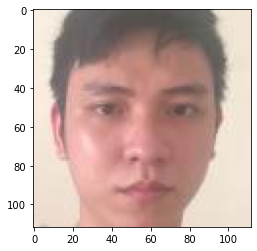

In [61]:
plt.imshow((img1+1)/2)

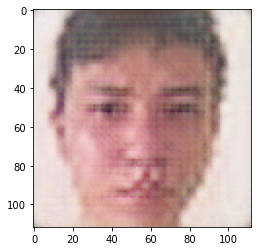

In [65]:
plt.imshow((o[0].cpu().permute(1, 2, 0).detach()))

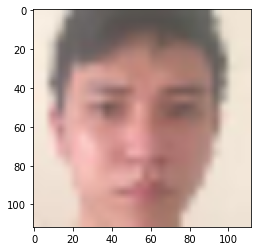

In [55]:
plt.imshow((img3+1)/2)